
## Indo ML Competition 
##  `Berchmans Kevin, Arunachalam, Rahul Venkat`

In [1]:
import os
import pandas as pd
from tensorflow.keras.layers import GlobalAveragePooling2D, Add, Input, Flatten
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tifffile

In [2]:
images =  os.listdir("E:/BHC Semester 3/Deep Learning/Datathon/train/train")

(1000, 754)

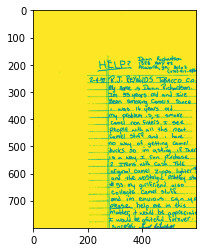

In [3]:
img = tifffile.imread("E:/BHC Semester 3/Deep Learning/Datathon/train/train/" + images[40])
import matplotlib.pyplot as plt
plt.imshow(img[100:900, 100:700]/255) 
img.shape

In [4]:
labels = pd.read_csv('train_labels.csv')

In [5]:
labels.shape

(16000, 2)

In [6]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Add, Input, Flatten
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
tf.config.run_functions_eagerly(True)

n = 7 # 44 layers
channels = [ 16*1.5, 32*1.5, 64*1.5 ]

inputs = Input(shape=(800, 600, 3))
x = Conv2D(channels[0], kernel_size=(7, 7), padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation(tf.nn.relu)(x)

for c in channels:
    for i in range(n):
        subsampling = i == 0 and c > 16
        strides = (2, 2) if subsampling else (1, 1)
        y = Conv2D(c, kernel_size=(3, 3), padding="same", strides=strides, kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x)
        y = BatchNormalization()(y)
        y = Activation(tf.nn.relu)(y)
        y = Conv2D(c, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)        
        if subsampling:
            x = Conv2D(c, kernel_size=(1, 1), strides=(2, 2), padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x)
        x = Add()([x, y])
        x = Activation(tf.nn.relu)(x)

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(3000, activation = tf.nn.relu)(x)
x = Dense(1000, activation = tf.nn.relu)(x)
outputs = Dense(16, activation=tf.nn.softmax, kernel_initializer="he_normal")(x)

model = Model(inputs=inputs, outputs=outputs)
model.type = "resnet" + str(6 * n + 2)

In [7]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 600, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 800, 600, 24) 3552        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 800, 600, 24) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 800, 600, 24) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [9]:
def get_f1(y_true, y_pred): 
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    possible_positives = K.sum(K.round(K.clip(y_true, 0.0, 1.0)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0.0, 1.0)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    
    return f1_val

In [10]:
from sklearn.metrics import f1_score, confusion_matrix
model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [ ]:
from PIL import Image
import numpy as np
for i, j in zip(labels['id'],labels['label']):
    path = './'+str(j)+'/'
    img = tifffile.imread('E:/BHC Semester 3/Deep Learning/Datathon/train/train/'+str(i)+'.tif')
    img = img[100:900, 100:700]/255
    image = Image.fromarray(img)
    image.convert('RGB').save(path+str(i)+'.png')

In [ ]:
ds_train = image_dataset_from_directory('./',
                                        labels = 'inferred',label_mode='categorical',color_mode = 'rgb',
                                        batch_size = 5,image_size = (800, 600),shuffle = True,seed = 123,
                                        validation_split = 0.1,subset = 'training',)

ds_validation = image_dataset_from_directory('./',
                                             labels = 'inferred',label_mode='categorical',color_mode = 'rgb',
                                             batch_size = 30,image_size = (800, 600),shuffle = True,seed = 123,
                                             validation_split = 0.1,subset = 'validation',)


model.fit(ds_train, epochs = 12,validation_data = ds_validation,batch_size = 30,
          callbacks = [EarlyStopping(monitor='loss', patience = 2)])